In [1]:
import numpy as np
import scipy as sp
import sympy as sy
import matplotlib.pyplot as plt

from qbasic.funçoes import edo,Valor_esperado
from qbasic.estados import bases
from qbasic.operador import destruiçao,Identidade
from qbasic.class_tijolo import ObjQuantico

from IPython.display import display, Math

# Aula 10: 

Nesse primeioro material iremos seguir o tutorial do site :  https://docs.scipy.org/doc/scipy/tutorial/sparse.html direto do site da scipy.

## Introdução :

O módulo `scipy.sparse` e seus submódulos fornecem ferramentas para trabalhar com matrizes esparsas. 
Matrizes esparsas são um tipo especial de matriz em que apenas algumas posições contêm dados. 

Isso permite representações compactas, nas quais somente as posições com dados são registradas. Existem diversos formatos de matrizes esparsas, cada um fazendo um equilíbrio diferente entre compressão e funcionalidade. Para começar, vamos construir uma matriz esparsa simples no formato Coordenado (COO, ou `coo_array`) e compará-la com uma matriz densa:

In [44]:
dense   = np.array([[1, 0, 0, 2], [0, 4, 1, 0], [0, 0, 5, 0]])
sparse  = sp.sparse.coo_array(dense)
print("Matriz Densa:")
print(sparse)

Matriz Densa:
<COOrdinate sparse array of dtype 'int64'
	with 5 stored elements and shape (3, 4)>
  Coords	Values
  (0, 0)	1
  (0, 3)	2
  (1, 1)	4
  (1, 2)	1
  (2, 2)	5


Observe que, em nossa matriz densa, temos cinco valores não nulos. Por exemplo, o número 2 está na posição 0,3, e o número 4 está na posição 1,1. Todos os outros valores são zeros. A matriz esparsa registra explicitamente esses cinco valores (veja os 5 elementos armazenados e o formato ((3,4)) e representa todos os zeros restantes como valores implícitos.


COO arrays cannot be subscripted or sliced:

In [45]:
print(dense)
print(dense[2, 2])
# sparse[2, 2]

[[1 0 0 2]
 [0 4 1 0]
 [0 0 5 0]]
5


COO arrays cannot be subscripted or sliced:

But, other formats, such as the Compressed Sparse Row (CSR) csr_array support slicing and element indexing:

In [46]:
sparse  = sp.sparse.csr_array(dense)
print(sparse)

<Compressed Sparse Row sparse array of dtype 'int64'
	with 5 stored elements and shape (3, 4)>
  Coords	Values
  (0, 0)	1
  (0, 3)	2
  (1, 1)	4
  (1, 2)	1
  (2, 2)	5


Multiplicação de matrizes

In [47]:
dense*dense

array([[ 1,  0,  0,  4],
       [ 0, 16,  1,  0],
       [ 0,  0, 25,  0]])

## Convertendo a classe base

In [48]:
class ObjQuantico_esparso:
    def __init__(self, data,latex_representation=None):
        self.dados = data
        self.latex_representation = latex_representation

    def definir_dados(self, data):
        self.dados = data

    def full(self):
        return self.dados.todense()
    
    def full_sparsa(self):
        return self.dados
    
    def dim(self):
        return len(self.dados.todense())
    
    def expM(self):
        # Convertendo para csc matriz pq é mais eficiente
        matrix = sp.sparse.csc_matrix(self.dados)
        matrix = sp.sparse.linalg.expm(matrix)
        return ObjQuantico_esparso(matrix) 
    
    def dag(self):
        return ObjQuantico_esparso(self.dados.transpose().conjugate())
    
    def traço(self):
        return float(self.dados.trace().real)
    
    def Autovalores(self):
        return np.linalg.eigvals(self.dados.todense())
    
    def Autovetores(self):
        return np.linalg.eig(self.dados.todense())[1]
    
    def AutoValor_Vetor(self):
        return np.linalg.eig(self.dados.todense())
    
    def __repr__(self):
        if self.latex_representation:
            display(Math(self.latex_representation))
        else:
            display(Math(sy.latex(sy.Matrix(self.dados.todense()))))
        return f"ObjQuantico: dim ={self.dim()} , shape = {self.dados.todense().shape}" 
                
    def __add__(self, other):
        if isinstance(other, ObjQuantico_esparso):  
            # Soma os dados de dois objetos ObjQuantico_esparso
            return ObjQuantico_esparso(self.dados + other.dados)
        else:
            raise TypeError(f"Soma não suportada entre {type(other)} e ObjQuantico")
        
    def __sub__(self, other):
        if isinstance(other, ObjQuantico_esparso):  
            # Subtração entre duas instâncias de ObjQuantico
            return ObjQuantico_esparso(self.dados - other.dados)
        else:
            raise TypeError(f"Subtração não suportada entre {type(other)} e ObjQuantico")
    
    def __mul__(self, other):
        # Multiplicação para diferentes tipos
        if isinstance(other, ObjQuantico_esparso):  
            # Multiplicação matricial com outra instância de ObjQuantico
            return ObjQuantico_esparso(self.dados.dot( other.dados))
        elif np.isscalar(other):  # Multiplicação por escalar
            return ObjQuantico_esparso(self.dados * other)
        else:
            raise TypeError(f"Multiplicação não suportada entre {type(other)} e ObjQuantico")

    def __rmul__(self, other):
        if np.isscalar(other):  # Multiplicação reversa por escalar
            return ObjQuantico_esparso(self.dados * other)
        else:
            raise TypeError(f"Multiplicação não suportada entre {type(other)} e ObjQuantico")
    
    def __truediv__(self, other):
        if isinstance(other, (int, float)):  # Divisão por um número escalar
            return ObjQuantico_esparso(self.dados / other)
        else:
            raise TypeError(f"Divisão não suportada entre {type(other)} e ObjQuantico")
    
    def __rtruediv__(self, other):
        if isinstance(other, (int, float)):  # Divisão invertida por um número escalar
            return ObjQuantico_esparso(other / self.dados)
        else:
            raise TypeError(f"Divisão não suportada entre {type(other)} e ObjQuantico")     
         
    def __pow__(self, power):
        if not isinstance(power, int) or power < 0:
            raise ValueError("A potência deve ser um inteiro não negativo.")
        
        # Obter a matriz identidade no formato esparso
        size = self.dados.shape[0]  # Número de linhas
        result = sp.sparse.identity(size, format='csr')  # Identidade esparsa no formato CSR
        
        # Multiplicação iterativa
        for _ in range(power):
            result = result @ self.dados  # Multiplicação esparsa eficiente
        return ObjQuantico_esparso(result)
    
    def __matmul__(self, other):
        """Implementa o operador @ para o produto tensorial."""
        if isinstance(other, ObjQuantico_esparso):
            return ObjQuantico_esparso(sp.sparse.kron(self.full_sparsa(), other.full_sparsa()))
        else:
            raise TypeError(f"Operador @ não suportado entre {type(self)} e {type(other)}")

In [49]:
dense   = np.array([[1j, 0,  0], [0, 4, 0j], [0, 0+1j, 1]])
dense   = 2*dense  - dense.T
dense   = sp.sparse.csr_array(dense)
print(dense)

<Compressed Sparse Row sparse array of dtype 'complex128'
	with 5 stored elements and shape (3, 3)>
  Coords	Values
  (0, 0)	1j
  (1, 1)	(4+0j)
  (1, 2)	-1j
  (2, 1)	2j
  (2, 2)	(1+0j)


###  Plote

In [50]:
# __repr__()
spar_var = ObjQuantico_esparso(dense)
spar_var

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

###  Full_sparsa

````python
def full_sparsa(self):
    return self.dados
````
Metodo novo para rotrno a matris esparsa no formado sparso emquanto que o full() continua retornando a matriz esparça completa.

In [51]:
# .full_sparsa()
print(spar_var.full_sparsa())

<Compressed Sparse Row sparse array of dtype 'complex128'
	with 5 stored elements and shape (3, 3)>
  Coords	Values
  (0, 0)	1j
  (1, 1)	(4+0j)
  (1, 2)	-1j
  (2, 1)	2j
  (2, 2)	(1+0j)


###  Dim

````python
def dim(self):
        return len(self.dados.todense())
````
Estamos calculado ca dimensão da matrix densa 

In [52]:
# dim()
spar_var.dim()

3

###  Dag

````python
def dag(self):
    return ObjQuantico_esparso(np.conjugate(self.dados.T))
````
vamos mudar as funçoes do numpa para scipy sparso

In [53]:
print(spar_var.full_sparsa().transpose())

<Compressed Sparse Column sparse array of dtype 'complex128'
	with 5 stored elements and shape (3, 3)>
  Coords	Values
  (0, 0)	1j
  (1, 1)	(4+0j)
  (2, 1)	-1j
  (1, 2)	2j
  (2, 2)	(1+0j)


In [54]:
print(spar_var.full_sparsa().conjugate())

<Compressed Sparse Row sparse array of dtype 'complex128'
	with 5 stored elements and shape (3, 3)>
  Coords	Values
  (0, 0)	-1j
  (1, 1)	(4-0j)
  (1, 2)	1j
  (2, 1)	-2j
  (2, 2)	(1-0j)


In [55]:
def dag(self):
    return ObjQuantico_esparso(self.dados.transpose().conjugate())

print(spar_var.full_sparsa().transpose().conjugate())

<Compressed Sparse Column sparse array of dtype 'complex128'
	with 5 stored elements and shape (3, 3)>
  Coords	Values
  (0, 0)	-1j
  (1, 1)	(4-0j)
  (2, 1)	1j
  (1, 2)	-2j
  (2, 2)	(1-0j)


###  Traço

````python
def traço(self):
    return np.trace(self.dados).real
````
vamos mudar as funçoes do numpy para scipy sparso

In [56]:
def traço(self):
    return self.dados.trace().real

spar_var.full_sparsa().trace().real

np.float64(5.0)

###  AutoValor

````python
    def Autovalores(self):
        return np.linalg.eigvals(self.dados)
````
vamos mudar as funçoes do numpy para scipy sparso

In [57]:
spar_var.full()

array([[0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 4.+0.j, 0.-1.j],
       [0.+0.j, 0.+2.j, 1.+0.j]])

In [58]:
sp.linalg.eig(spar_var.full())

(array([0.43844719+0.j, 4.56155281+0.j, 0.        +1.j]),
 array([[-0.        -0.j        ,  0.        -0.j        ,
          1.        +0.j        ],
        [-0.        +0.27032301j,  0.87192821+0.j        ,
          0.        +0.j        ],
        [ 0.96276969+0.j        ,  0.        +0.48963374j,
          0.        +0.j        ]]))

Ha alguma limitaçoes no scipy.sparse.linalg.eigs , a principal é que ele não consegue calcular todos os autovalores e auto vetores, das matrizes esparsas. 

In [59]:
# Nesse enxemplo para k >1 ja não fuciona pq a matriz 3x3 
sp.sparse.linalg.eigs(spar_var.full_sparsa(),k=1)

(array([4.56155281-3.33066907e-16j]),
 array([[ 1.11022302e-16-1.94289029e-16j],
        [-4.79441868e-01+7.28281743e-01j],
        [-4.08968661e-01-2.69231930e-01j]]))

In [60]:
def Autovalores(self):
    return np.linalg.eigvals(self.dados.todense())

np.linalg.eigvals(spar_var.full())

array([0.43844719+0.j, 4.56155281+0.j, 0.        +1.j])

o mesmo vale apara as outra funções

In [61]:
def Autovetores(self):
    return np.linalg.eig(self.dados.todense())[1]

def AutoValor_Vetor(self):
    return np.linalg.eig(self.dados.todense())

## Convertendo todos os operadores

### Identidade 

```python
def Identidade(N):
    matriz = np.identity(N)
    return ObjQuantico(matriz) 
```

In [62]:
sp.sparse.identity(3).toarray()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Criado a função 

In [63]:
def Identidade(N,sparsa=False):
    if sparsa ==True:
        matriz = sp.sparse.identity(N)
        return ObjQuantico_esparso(matriz)
    else:
        matriz = np.identity(N)
        return ObjQuantico(matriz) 

In [64]:
N = 3 
I = Identidade(N,sparsa=True)
I

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

In [65]:
I+I #Soma

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

In [66]:
I-I #Substração

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

In [67]:
(1+7j)*I#Multiplicaçao

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

In [68]:
I/10

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

In [69]:
(1j*I)**2

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

### Destruição

```python
def destruiçao(N):
    subdiag = np.sqrt(np.arange(1, N))# Monta os elementos na subdiagonal
    dt      = np.diag(subdiag, k=1) # Operador de destruição
    return ObjQuantico(dt)
```


In [70]:
def destruiçao(N,sparsa=False):
    if sparsa ==True:
        subdiag = np.sqrt(np.arange(1, N))
        matriz  = sp.sparse.diags(subdiag,offsets=1)
        return ObjQuantico_esparso(matriz)
    else:
        subdiag = np.sqrt(np.arange(1, N)) # Monta os elementos na subdiagonal
        matriz  = np.diag(subdiag, k=1) # Operador de destruição
        return ObjQuantico(matriz) 

In [71]:
basefock = 2

a =destruiçao(basefock,sparsa=True)@Identidade(2,sparsa=True)
a*(a.dag())


<IPython.core.display.Math object>

ObjQuantico: dim =4 , shape = (4, 4)

### Criação

In [72]:
def criaçao(N,sparsa=False):
    return  destruiçao(N,sparsa=sparsa).dag()    
   

### Operador x e P

In [73]:
def operador_p(N,sparsa=False):
    return -1j*(destruiçao(N,sparsa) - criaçao(N,sparsa))/np.sqrt(2)   

In [74]:
print(operador_p(3,sparsa=True).full_sparsa())

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 4 stored elements and shape (3, 3)>
  Coords	Values
  (0, 1)	-0.7071067811865475j
  (1, 0)	0.7071067811865475j
  (1, 2)	-1j
  (2, 1)	1j


In [75]:
def operador_x(N,sparsa=False):
    return (destruiçao(N,sparsa) + criaçao(N,sparsa))/np.sqrt(2) 

In [76]:
print(operador_x(3,sparsa=True).full_sparsa())

<DIAgonal sparse matrix of dtype 'float64'
	with 4 stored elements (2 diagonals) and shape (3, 3)>
  Coords	Values
  (1, 0)	0.7071067811865475
  (2, 1)	1.0
  (0, 1)	0.7071067811865475
  (1, 2)	1.0


### Matrizes de pauli

In [77]:
def pauliX(sparsa=False):
    latex_representation = r"$$ \hat{\sigma_x} $$"
    if sparsa ==  False:
        m = np.array([[ 0, 1 ],[ 1, 0 ]])
        return ObjQuantico(m,latex_representation)
    else:
        # Criando a matriz diretamente no formato esparso COO
        data = [1, 1]
        row = [0, 1]
        col = [1, 0]
        m   = sp.sparse.coo_array((data, (row, col)), shape=(2, 2))
        return ObjQuantico_esparso(m,latex_representation) 

def pauliY(sparsa=False):
    latex_representation = r"$$ \hat{\sigma_y} $$"
    
    if sparsa:
        # Criando a matriz diretamente no formato esparso COO
        data = [-1j, 1j]
        row = [0, 1]
        col = [1, 0]
        m   = sp.sparse.coo_array((data, (row, col)), shape=(2, 2))
        return ObjQuantico_esparso(m, latex_representation)
    else:
        # Criando a matriz no formato denso
        m = np.array([[0, -1j], [1j, 0]])
        return ObjQuantico(m, latex_representation)

def pauliZ(sparsa=False):
    latex_representation = r"$$ \hat{\sigma_z} $$"
    
    if sparsa:
        # Criando a matriz diretamente no formato esparso COO
        data = [1, -1]
        row = [0, 1]
        col = [0, 1]
        m   =  sp.sparse.coo_array((data, (row, col)), shape=(2, 2))
        return ObjQuantico_esparso(m, latex_representation)
    else:
        # Criando a matriz no formato denso
        m = np.array([[1, 0], [0, -1]])
        return ObjQuantico(m, latex_representation)

In [78]:
m = pauliY(sparsa=True)
m

<IPython.core.display.Math object>

ObjQuantico: dim =2 , shape = (2, 2)

In [79]:
print(m.full_sparsa())

<COOrdinate sparse array of dtype 'complex128'
	with 2 stored elements and shape (2, 2)>
  Coords	Values
  (0, 1)	(-0-1j)
  (1, 0)	1j


In [80]:
m.traço()

0.0

In [81]:
m.dag()

<IPython.core.display.Math object>

ObjQuantico: dim =2 , shape = (2, 2)

In [82]:
m @ m.dag()

<IPython.core.display.Math object>

ObjQuantico: dim =4 , shape = (4, 4)

### Matriz densidade

In [83]:
def matrizdensidade(probabilities=None, estados=None, puro=True,sparsa=False): 
    if puro == True:
        rho = estados*estados.dag()
        if sparsa==True:
            return ObjQuantico_esparso(sp.sparse.coo_array(rho.full()))
        else:
            return rho
    
    else:    
        # Verificar se as probabilidades somam 1
        if not np.isclose(sum(probabilities), 1):
            raise ValueError("As probabilidades devem somar 1.")
        
        # Verificar se cada estado está normalizado
        for state in estados:
            if not np.isclose(np.linalg.norm(state.full()), 1):
                raise ValueError("Todos os estados devem ser normalizados.")
             
        # Criar a matriz densidade
        dimensao = estados[0].full().shape[0] # pega o primeiro estado, em seguida a dimensao do estado
        rho = np.zeros((dimensao, dimensao), dtype=complex)
        for p, state in zip(probabilities, estados):
            rho += p * np.outer(state.full(), state.dag().full())  # |ψ⟩⟨ψ|
            
        if sparsa == True:
            return ObjQuantico_esparso(sp.sparse.coo_array(rho))
        else:
            return ObjQuantico(rho)

In [84]:
estado = bases(N=3,n=1)
estado

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 1)

In [85]:
matrizdensidade(estados=estado) # densa

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

In [86]:
matrizdensidade(estados=estado,sparsa=True) # Esparsa

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

In [87]:
matrizdensidade(estados=estado,sparsa=True).full_sparsa() # Esparsa

<COOrdinate sparse array of dtype 'complex128'
	with 1 stored elements and shape (3, 3)>

In [88]:
estados = [bases(N=3,n=0),bases(N=3,n=1),bases(N=3,n=2)]
probabilidades = [0.25,0.25,0.5]

matrizdensidade(probabilidades, estados, puro=False,sparsa=False)

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 3)

In [89]:
print(matrizdensidade(probabilidades, estados, puro=False,sparsa=True).full_sparsa())

<COOrdinate sparse array of dtype 'complex128'
	with 3 stored elements and shape (3, 3)>
  Coords	Values
  (0, 0)	(0.25+0j)
  (1, 1)	(0.25+0j)
  (2, 2)	(0.5+0j)


## Convertendo todos os estado

### Bases

In [90]:
def bases(N,n,sparsa=False):
    if sparsa == False:
        estadoinicial = np.zeros(shape=(N, 1),dtype=complex)
        estadoinicial[n, 0] = 1
        return ObjQuantico(estadoinicial) 
    else:
        estadoinicial = sp.sparse.lil_array((N, 1),dtype=complex)
        estadoinicial[n:n+1] =  1 
        return ObjQuantico_esparso(estadoinicial) 


In [91]:
N = 5
n = 1
bases(N,n)

<IPython.core.display.Math object>

ObjQuantico: dim =5 , shape = (5, 1)

In [92]:
bases(N,n,sparsa=True)

<IPython.core.display.Math object>

ObjQuantico: dim =5 , shape = (5, 1)

### kets e bras

In [93]:
def ket(entrada,sparsa=False):
    if isinstance(entrada, (int, float)) or (isinstance(entrada, str) and entrada in ('0', '1')):
        
        latex_representation = rf"$$ \ket{entrada} $$"
        
        if sparsa == False:
            dados = bases(N=2,n=int(entrada),sparsa=sparsa).full()
            return ObjQuantico(dados, latex_representation)
        else:
            dados = bases(N=2,n=int(entrada),sparsa=sparsa).full_sparsa()
            return ObjQuantico_esparso(dados, latex_representation)
    else:
        print("Entrada invalida / tente usar outra função( sugestão bases) ")
    

In [94]:
ket(0),ket(1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(ObjQuantico: dim =2 , shape = (2, 1), ObjQuantico: dim =2 , shape = (2, 1))

In [95]:
ket(0,sparsa=True).full_sparsa(),ket(1,sparsa=True).full_sparsa()

(<List of Lists sparse array of dtype 'complex128'
 	with 1 stored elements and shape (2, 1)>,
 <List of Lists sparse array of dtype 'complex128'
 	with 1 stored elements and shape (2, 1)>)

In [96]:
def bra(entrada,sparsa=False):
    if isinstance(entrada, (int, float)) or (isinstance(entrada, str) and entrada in ('0', '1')):
        
        latex_representation = rf"$$ \bra{entrada} $$"
        
        if sparsa == False:
            dados = bases(N=2,n=int(entrada),sparsa=sparsa).dag().full()
            return ObjQuantico(dados, latex_representation)
        else:
            dados = bases(N=2,n=int(entrada),sparsa=sparsa).dag().full_sparsa()
            return ObjQuantico_esparso(dados, latex_representation)
    else:
        print("Entrada invalida / tente usar outra função( sugestão bases) ")
    

In [97]:
bra(0),bra(1),bra(0).full(),bra(1).full()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(ObjQuantico: dim =1 , shape = (1, 2),
 ObjQuantico: dim =1 , shape = (1, 2),
 array([[1.-0.j, 0.-0.j]]),
 array([[0.-0.j, 1.-0.j]]))

In [98]:
bra(0,sparsa=True),bra(1,sparsa=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(ObjQuantico: dim =1 , shape = (1, 2), ObjQuantico: dim =1 , shape = (1, 2))

### Fock

In [99]:
def Fock(N, n=0,sparsa=False):
    return bases(N, n,sparsa)

In [100]:
Fock(N=10)

<IPython.core.display.Math object>

ObjQuantico: dim =10 , shape = (10, 1)

### Coerente

In [101]:
def coerente(N,alpha,metodo ="operador",sparsa = False):
    
    if metodo == "operador" :
        estado  = bases(N,0,sparsa) # estado inicinal no vacuo
        D       = alpha * destruiçao(N,sparsa).dag() - np.conj(alpha) * destruiçao(N,sparsa)
        D       = D.expM()
        return D*estado
        
    elif metodo == "analitico":    # implementar o metodo de matrizes esparsas
        if sparsa ==False:
            estado  = np.zeros(shape=(N,1),dtype=complex)
            n       = np.arange(N)
            estado[:,0] = np.exp(-(abs(alpha) ** 2 )/ 2.0) * (alpha**n)/np.sqrt(sp.special.factorial(n))
            return ObjQuantico(estado)     
        else:
            estado = sp.sparse.lil_array((N, 1),dtype=complex)
            estado[:] = np.exp(-(abs(alpha) ** 2 )/ 2.0) * (alpha**np.arange(N))/np.sqrt(sp.special.factorial(np.arange(N)))
            return ObjQuantico_esparso(estado)   
    else:
        raise TypeError(
            "A opção de método tem as seguintes opções :'operador' ou 'analitico'")

In [102]:
alpha = 0.1
N=3
coerente(N,alpha,metodo="analitico")

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 1)

In [103]:
coerente(N,alpha,metodo="analitico",sparsa=True)

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 1)

In [104]:
coerente(N,alpha,metodo="operador",sparsa=True)

<IPython.core.display.Math object>

ObjQuantico: dim =3 , shape = (3, 1)

# Convertendo o solve

### TODO List: Criar um Solver para Resolver EDO Linear de Primeira Ordem

1. **Definir a EDO Linear de Primeira Ordem:**
    - Definir a equação diferencial dx/dt = A(t)x + b, onde A é uma matriz esparsa e b é um vetor.

2. **Importar Bibliotecas Necessárias:**
    - Importar `numpy` para operações numéricas.
    - Importar `scipy.sparse` para manipulação de matrizes esparsas.
    - Importar `scipy.integrate` para métodos de integração.

3. **Definir a Função para a EDO:**
    - Criar uma função que representa a EDO dx/dt = A(t)x + b.

4. **Configurar Parâmetros Iniciais:**
    - Definir os valores iniciais para t0, tf, e y0.
    - Definir a matriz esparsa A e o vetor b.

5. **Escolher o Método de Integração:**
    - Selecionar um método de integração adequado, como `solve_ivp` do `scipy.integrate`.

6. **Implementar o Solver:**
    - Implementar o solver utilizando `solve_ivp` para resolver a EDO.

7. **Testar o Solver:**
    - Testar o solver com diferentes matrizes esparsas A e vetores b.
    - Verificar a precisão e eficiência do solver.

8. **Visualizar os Resultados:**
    - Plotar os resultados da solução da EDO.
    - Analisar o comportamento da solução ao longo do tempo.

9. **Documentar o Código:**
    - Adicionar comentários e documentação ao código para facilitar a compreensão.

10. **Otimizar o Código:**
     - Otimizar o código para melhorar a performance, se necessário.

11. **Salvar e Compartilhar:**
     - Salvar o notebook e compartilhar com colegas para revisão e feedback.

In [2]:
from scipy.sparse import csr_matrix

# Definir uma matriz esparsa 3x3 e vetor b constante
A_sparse = csr_matrix([
    [0, 1, 0],
    [0, 0, 1],
    [-2, -3, -4]
])

b = np.array([0, 0, 0])  # sistema homogêneo

# Condição inicial
y0 = np.array([1, 0, 0])
t0, tf = 0, 10
t_eval = np.linspace(t0, tf, 300)

# Função da EDO com matriz esparsa
def ode_function_sparse(t, x):
    return A_sparse.dot(x) + b

In [7]:
np.dot(A_sparse.todense(),y0)

matrix([[ 0,  0, -2]])

In [3]:
A_sparse.dot(y0)

array([ 0,  0, -2])

In [80]:
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from scipy.sparse import csc_matrix

def exact_solution(t, t0, y0, M, b):

    delta_t = t - t0
    exp_M_dt = expm(M * delta_t)  # Calcula e^(M * delta_t)
    if np.linalg.det(M) != 0:  # Verifica se M é inversível
        M_inv = np.linalg.inv(M)
        correction = M_inv @ (exp_M_dt - np.eye(M.shape[0])) @ b
    else:
        # Caso M não seja inversível, apenas considera o termo homogêneo
        correction = np.zeros_like(y0)
    return exp_M_dt @ y0 + correction

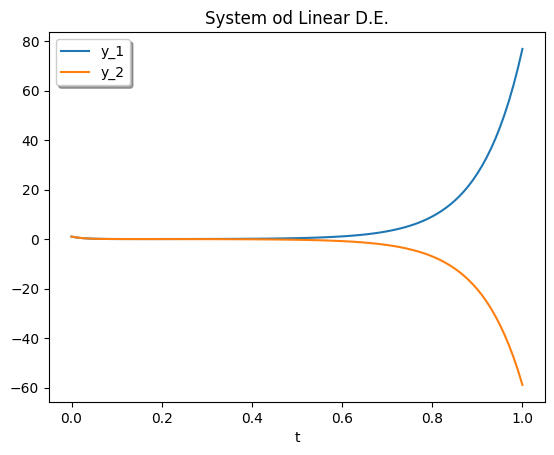

0.0020519709851534707
0.002088636073221356


In [81]:
np.random.seed(42)
# Parâmetros do problema
M  = -30*np.random.random((2,2))  # Matriz 2x2 de exemplo
b  = np.array([0, 0])           # Vetor constante de exemplo
y0 = np.array([1, 1])          # Condição inicial
t0, tf = 0, 1                 # Intervalo de tempo

M  = csc_matrix(M)  # Representação esparsa

# Função para o sistema dY/dx = A Y
def sistema(t, y):
    return M @ y  # Produto matriz-vetor otimizado

# Resolver usando solve_ivp com método para sistemas rígidos (BDF)
solution = solve_ivp(
    sistema, (t0, tf), y0,
    method ='RK45', 
    t_eval = np.linspace(t0, tf, 101))

plt.plot(solution.t,solution.y[0])
plt.plot(solution.t,solution.y[1])
plt.xlabel('t')
plt.legend(['y_1', 'y_2'], shadow=True)
plt.title('System od Linear D.E.')
plt.show()

# Solução exata
y_exact_all = np.array([exact_solution(t, t0, y0, M.todense(), b) for t in solution.t])

# Erro absoluto
erro_absoluto = np.mean(np.abs(solution.y[0]-y_exact_all[:,0,0]))
print(erro_absoluto)

erro_absoluto = np.mean(np.abs(solution.y[1]- y_exact_all[:,0,1]))
print(erro_absoluto)
